The goal of this project was to build a "successful shot probability" GUI with Python, that allows a user to choose a NBA basketball player to throw the ball as well as the position from where the player shoots the basketball and the other defends the shot. After choosing those parameters, the GUI then shows the probability of the shot to go in. For that, the GUI contains an abstract version of one side of a basketball court where the user can choose the positions of both players by clicking on the court, the shooter can be selected via a dropdown menu. The data I use contains every shot that was taken in the games of the 2013 and 2014 NBA seasons, which I got from https://github.com/hwchase17/sportvu.

# Imports

In [1]:
#standard imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import math
import warnings

#GUI imports
import tkinter as tk
from tkinter.filedialog import askopenfilename
from tkinter import ttk
from PIL import Image, ImageTk
import tkinter.simpledialog
from tkinter.messagebox import showinfo

# Data

In [2]:
#read in data as csv file
#year 2013
joined13 = pd.read_csv("Data/joined_shots_2013.csv")

#year 2014
joined14 = pd.read_csv("Data/joined_shots_2014.csv")

#put both joined csv files together
joined = pd.concat([joined13, joined14], ignore_index = True)

In [3]:
#all available columns
joined.columns

Index(['Unnamed: 0', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'DRIBBLES', 'FGM', 'FINAL_MARGIN', 'GAME_CLOCK',
       'GAME_ID', 'GAME_ID.1', 'LOCATION', 'MATCHUP', 'PERIOD', 'PERIOD.1',
       'PTS', 'PTS_TYPE', 'SHOT_CLOCK', 'SHOT_DIST', 'SHOT_NUMBER',
       'SHOT_RESULT', 'TOUCH_TIME', 'W', 'GRID_TYPE', 'GAME_EVENT_ID',
       'PLAYER_ID', 'PLAYER_ID.1', 'PLAYER_NAME', 'TEAM_ID',
       'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE',
       'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG'],
      dtype='object')

In [4]:
joined.head(10)

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0
5,1,"Andersen, Chris",2365.0,1.6,13.0,0.0,-7.0,9:36,21300230,21300230,...,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,9.0,-98.0,4.0,1.0,0.0
6,2,"Cole, Norris",202708.0,2.4,5.0,0.0,-7.0,8:21,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28.0,-100.0,268.0,1.0,0.0
7,0,"Jones, Terrence",203093.0,3.4,6.0,0.0,-6.0,10:48,21300103,21300103,...,Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3.0,2.0,30.0,1.0,0.0
8,1,"Lin, Jeremy",202391.0,2.4,8.0,0.0,-6.0,10:30,21300103,21300103,...,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21.0,145.0,163.0,1.0,0.0
9,2,"Beverley, Patrick",201976.0,3.5,2.0,1.0,-6.0,8:26,21300103,21300103,...,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18.0,-97.0,153.0,1.0,1.0


In [5]:
#only use necessary columns
joined = joined[["CLOSE_DEF_DIST", "SHOT_CLOCK", "PLAYER_ID", "PLAYER_NAME", "SHOT_DISTANCE", "LOC_X", "LOC_Y", "SHOT_MADE_FLAG"]]

There are 576 different IDs of players that took a shot in the dataset, but only different 575 players.

In [6]:
#number of different players in the dataset
print("Number of different IDs: " + str(joined.PLAYER_ID.nunique()))
print("Number of different players: " + str(joined.PLAYER_NAME.nunique()))

Number of different IDs: 576
Number of different players: 575


After adding all unique combinations of players with their ID to a list, a quick check of those combinations identified the player Tony Mitchell as the player with two IDs. Mitchell played for the Detroit Pistons in the 2013-14 season. He was waived during the season and later reassigned, which could be the reason why he has two IDs.

In [7]:
#player list for finding the player with two IDs
player_listID = []
for player in range(len(joined)):
    if joined["PLAYER_NAME"][player] + " " + str(joined["PLAYER_ID"][player]) not in player_listID:
        player_listID.append(joined["PLAYER_NAME"][player] + " " + str(joined["PLAYER_ID"][player]))
player_listID.sort()

In [8]:
#create list of all player names for the dropdown menu in the GUI
player_list = []
for name in joined["PLAYER_NAME"]:
    if name not in player_list:
        player_list.append(name)
player_list.sort()

## Visualizations

### Kobe vs Dirk visualizations

The plots show that both players had pretty similar shot tendencies regarding the shot distance and how many seconds where left when the shot was taken. The positions where their shots were taken from are also similar. However, due to major injuries in the period from which the data originate, Kobe had significantly fewer shots than Dirk.

In [9]:
#create df that contains only shot entries by Kobe and Dirk
kd_df = joined.loc[(joined["PLAYER_NAME"] == "Kobe Bryant") | (joined["PLAYER_NAME"] == "Dirk Nowitzki")]

print("Amount of shots Kobe took: " + str(len(kd_df[kd_df["PLAYER_NAME"] == "Kobe Bryant"])))
print("Amount of shots Dirk took: " + str(len(kd_df[kd_df["PLAYER_NAME"] == "Dirk Nowitzki"])))

Amount of shots Kobe took: 801
Amount of shots Dirk took: 2330


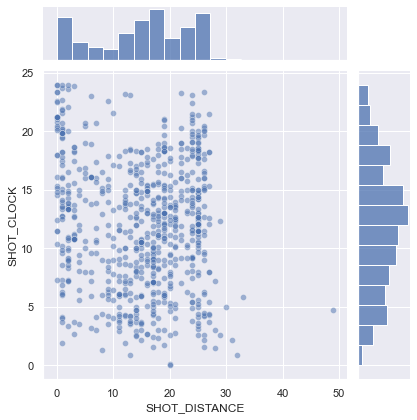

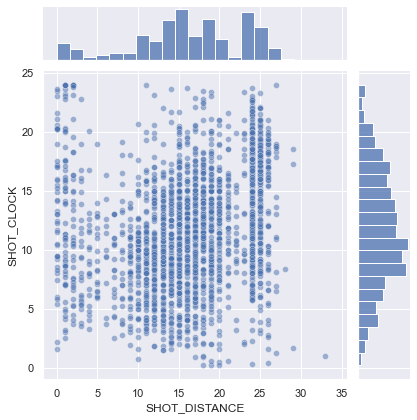

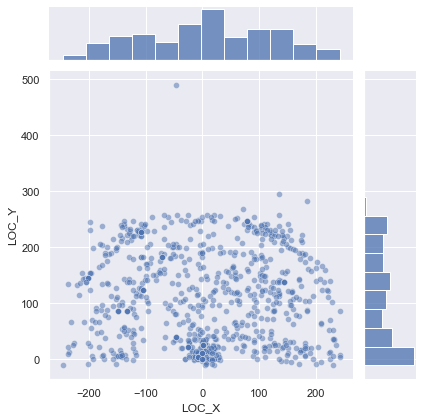

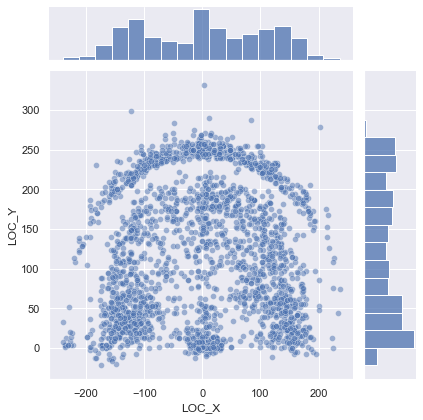

In [10]:
fig_kd, axis_kd = plt.subplots(2, 2)
fig_kd.tight_layout()

sns.set()

#shot distance by seconds left on shot clock
sns.jointplot(data = kd_df[kd_df["PLAYER_NAME"] == "Kobe Bryant"], x = "SHOT_DISTANCE", y = "SHOT_CLOCK", alpha = 0.5, ax = axis_kd[0, 0])
sns.jointplot(data = kd_df[kd_df["PLAYER_NAME"] == "Dirk Nowitzki"], x = "SHOT_DISTANCE", y = "SHOT_CLOCK", alpha = 0.5, ax = axis_kd[0, 1])

#location of shots
sns.jointplot(data = kd_df[kd_df["PLAYER_NAME"] == "Kobe Bryant"], x = "LOC_X", y = "LOC_Y", alpha = 0.5, ax = axis_kd[1, 0])
sns.jointplot(data = kd_df[kd_df["PLAYER_NAME"] == "Dirk Nowitzki"], x = "LOC_X", y = "LOC_Y", alpha = 0.5, ax = axis_kd[1, 1])

#close empty subplots
plt.close(1)

plt.show()

### General visualizations

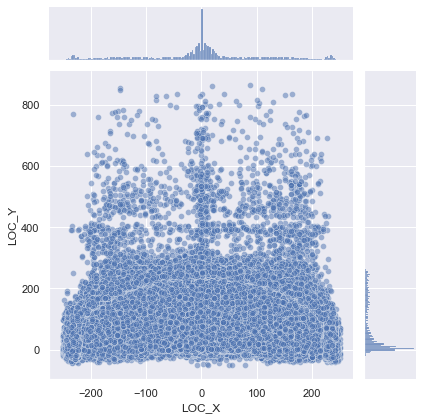

In [11]:
#shot locations
sns.jointplot(data = joined, x = "LOC_X", y = "LOC_Y", alpha = 0.5)
plt.show()

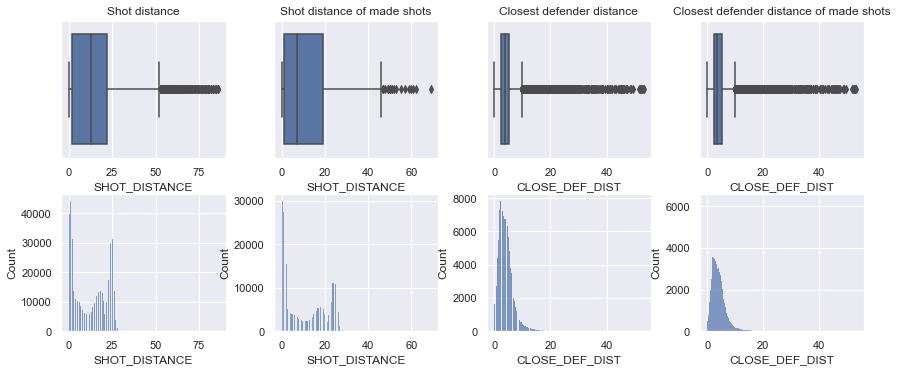

In [12]:
#visualize distributions of shot distance (when shot was successful)
#and distance of the closest defender (when shot was successful)
figure_gen, axis_gen = plt.subplots(2, 4, figsize = (12, 5))
figure_gen.tight_layout()

sns.boxplot(data = joined, x = "SHOT_DISTANCE", ax = axis_gen[0, 0]).set(title = "Shot distance")

sns.histplot(joined["SHOT_DISTANCE"], ax = axis_gen[1, 0])

sns.boxplot(x = joined[joined["SHOT_MADE_FLAG"] == 1]["SHOT_DISTANCE"], ax = axis_gen[0, 1]).set(title = "Shot distance of made shots")

sns.histplot(joined[joined["SHOT_MADE_FLAG"] == 1]["SHOT_DISTANCE"], ax = axis_gen[1, 1])

sns.boxplot(data = joined, x = "CLOSE_DEF_DIST", ax = axis_gen[0, 2]).set(title = "Closest defender distance")

sns.histplot(joined["CLOSE_DEF_DIST"], ax = axis_gen[1, 2])

sns.boxplot(x = joined[joined["SHOT_MADE_FLAG"] == 1]["CLOSE_DEF_DIST"], ax = axis_gen[0, 3]).set(title = "Closest defender distance of made shots")

sns.histplot(joined[joined["SHOT_MADE_FLAG"] == 1]["CLOSE_DEF_DIST"], ax = axis_gen[1, 3])

plt.show()

## Player dictionary

In [13]:
#create a dict that maps the player to his correct ID
player_dict = {}

for i in range(len(joined)):
    if joined["PLAYER_ID"][i] in player_dict:
        pass
    else:
        player_dict[joined["PLAYER_ID"][i]] = joined["PLAYER_NAME"][i]

In [14]:
key_list = list(player_dict.keys())
val_list = list(player_dict.values())

def player_id(player):
    """
    Returns the correct ID for the chosen player.

            Parameters:
                    player (str)    : name of the player

            Returns:
                    player_id (int) : ID of the player
    """
    
    position = val_list.index(player)
    player_id = key_list[position]
    return player_id

# Regression

I tried both simple linear regression and random forest for building the model. Although the linear regression is slighlty faster to fit, I chose to use random forest because its r-squared value (0.53) is much larger than that of the linear regression model (0.05).

## Simple Linear Regression

In [15]:
x = joined[["SHOT_DISTANCE", "PLAYER_ID", "CLOSE_DEF_DIST"]]
y = joined["SHOT_MADE_FLAG"]

In [16]:
#create a simple linear regression model and show its summary
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SHOT_MADE_FLAG   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7117.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:21:14   Log-Likelihood:            -2.7914e+05
No. Observations:              401495   AIC:                         5.583e+05
Df Residuals:                  401491   BIC:                         5.583e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5333      0.002    255.929      0.000       0.529       0.537
SHOT_DISTANCE     -0.0131   8.97e-05   -145.995      0.000      -0.013      -0.013
PLAYER_ID      -9.476e-08   9.49e-09     -9.987      0.000   -1.13e-07   -7.62e-08
CLOSE_DEF_DIST     0.0229      0.000     70.673      0.000       0.022       0.023
==============================================================================
Omnibus:                  1601424.517   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55172.008
Skew:                           0.189   Prob(JB):                         0.00
Kurtosis:                       1.224   Cond. No.                     4.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Random Forest

In [17]:
X_rf = joined[["SHOT_DISTANCE", "PLAYER_ID", "CLOSE_DEF_DIST"]]
y_rf = joined["SHOT_MADE_FLAG"]

#create a random forest model and print its r-squared value
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
randFor = regressor.fit(X_rf, y_rf)
randFor.score(X_rf, y_rf)

0.5350627791239944

In [18]:
def shot_prediction(player, shot_distance, def_dist):
    """
    Predicts the probability of a successful shot.

            Parameters:
                    player (str)          : name of the player
                    shot_distance (int)   : distance of the shot in ft

            Returns:
                    pred_percentage (int) : probability of a successful shot
    """
    
    prediction = regressor.predict([[shot_distance, player_id(player), def_dist]])[0]
    pred_percentage = round(prediction, 3) * 100
    return pred_percentage

In [19]:
#ignore UserWarnings that are displayed when probability is calculated
warnings.filterwarnings("ignore", category = UserWarning)

In [20]:
#example of the shot_prediction function
shot_prediction("Kobe Bryant", 15, 1.5)

50.0

# GUI

## Functions for the GUI

In [21]:
def pred_on_ok():
    """
    Uses the entered player name and entered distance to predict and displays
    the probability of the shot going in.

            Parameters:
                    None

            Returns:
                    None
    """
    
    name = chosen_player.get()
    dist_to_net = get_dist(295, 125, x_player, y_player)
    dist_to_def = get_dist(x_player, y_player, x_def, y_def)
    prediction = shot_prediction(name, dist_to_net, dist_to_def)
    showinfo(title='Information',
             message="When the player {} takes a shot with a distance of {} ft from the basket " \
                     "and a distance of {} ft to the closest defender, " \
                     "the estimated probability of scoring is {} %".format(name, dist_to_net, dist_to_def, prediction))

def getorigin_shot(eventorigin):
    """
    Creates a red circle at the position of the mouse click for the shooter.

            Parameters:
                    eventorigin (event) : position of mouse click by the user

            Returns:
                    None
    """
    
    global x_player, y_player, player_pos, net_dist_var
    x_player = eventorigin.x
    y_player = eventorigin.y
    #restrict "clickable" space to edges of the basketball court image
    if x_player >= 70 and x_player <= 520 and y_player >= 83 and y_player <= 506:
        #print(x_player, y_player)
        #print(get_dist(295, 125, x_player, y_player))
        w.delete(player_pos)
        player_pos = w.create_oval(x_player, y_player, x_player+10, y_player+10, fill = "red")
        net_dist_var.set(str(get_dist(295, 125, x_player, y_player)) + " ft")

def getorigin_def(eventorigin):
    """
    Creates a blue circle at the position of the mouse click for the defender.

            Parameters:
                    eventorigin (event) : position of mouse click by the user

            Returns:
                    None
    """
   
    global x_def, y_def, def_pos
    x_def = eventorigin.x
    y_def = eventorigin.y
    #restrict "clickable" space to edges of the basketball court image
    if x_def >= 70 and x_def <= 520 and y_def >= 83 and y_def <= 506:
        #print(x_def, y_def)
        #print(get_dist(x_player, y_player, x_def, y_def))
        w.delete(def_pos)
        def_pos = w.create_oval(x_def, y_def, x_def+10, y_def+10, fill = "blue")
        def_dist_var.set(str(get_dist(x_player, y_player, x_def, y_def)) + " ft")

def get_dist(x0, y0, x1, y1):
    """
    Transforms the distance of two coordinates to the distance in ft by using the euclidean distance and 
    dividing the result by 9, because with the size of the court in the GUI, 9 px equal 1 ft.

            Parameters:
                        x0 (int)  : x-coordinate of the first point
                        y0 (int)  : y-coordinate of the first point
                        x1 (int)  : x-coordinate of the second point
                        y1 (int)  : y-coordinate of the second point

            Returns:
                    ft_dist (int) : distance bewteen the two coordinates in ft
    """
    
    px_dist = math.sqrt((x0 - x1)**2 + (y0 - y1)**2)
    ft_dist = round(px_dist/9, 2)
    return ft_dist

def change_label_net(*args):
    """
    Changes the coordinate distance to the net to the distance in ft.

            Parameters:
                    *args (arguments) : position of mouse click by the user

            Returns:
                    None
    """
    
    net_dist_label.config(text = net_dist_text + net_dist_var.get())

def change_label_def(*args):
    """
    Changes the coordinate distance to the net to the distance in ft.

            Parameters:
                    *args (arguments) : position of mouse click by the user

            Returns:
                    None
    """
    
    def_dist_label.config(text = def_dist_text + def_dist_var.get())
    
#if the checkbox is unselected, the user will be able to adjust the shooters position,
#otherwise the defenders position
def checkbox_choosing():
    if checkbox_var.get() == 0:
        w.bind("<Button 1>", getorigin_shot)
    else:
        w.bind("<Button 1>", getorigin_def)

## Design of the GUI

In [22]:
#create a window with a title and two labels, both above a text field, where the user can enter the player
#and the shot distance for the prediction
root = tk.Tk()
root.title("Player and shot selection")
root.resizable(width=False, height = False)
root.geometry("1200x700")

#description label
descr_label = ttk.Label(root, text = "This GUI allows you to click anywhere on the basketball court to select the " \
                        "position \n of the shooter and the defender. "
                        "Check the 'Defender' box to be able to set \n the defenders position. \n" \
                        "To obtain the probability of a successful shot, click on the 'Get probability' button \n" \
                        "after selecting a name and the positions of both players.")
descr_label.place(x = 610, y = 435)

ttk.Label(text='Player selection (ex: Kobe Bryant, Dirk Nowitzki)').place(x=610, y=155)

#create dropdown list of all available players 
chosen_player = tk.StringVar()
players = ttk.OptionMenu(root, chosen_player, *player_list)
chosen_player.set(player_list[0])
players.place(x = 610, y = 185)

#show the chosen distance of the shooter to the net as a label
net_dist_var = tk.StringVar()
net_dist_label = ttk.Label(root)
net_dist_text = "Distance of the shooting player to the net: "
net_dist_label.config(text = net_dist_text) #empty label
net_dist_var.trace('w', change_label_net)
net_dist_label.place(x = 610, y = 235)

#show the chosen distance of the defender to the shooter as a label
def_dist_var = tk.StringVar()
def_dist_label = ttk.Label(root)
def_dist_text = "Distance of the shooting player to the closest defender: "
def_dist_label.config(text = def_dist_text) #empty label
def_dist_var.trace('w', change_label_def)
def_dist_label.place(x = 610, y = 285)

#create OK button to print the prediction when pressed
ttk.Button(root, text = 'Get probability', command = pred_on_ok).place(x=610, y=385)

#setting up a tkinter canvas
w = tk.Canvas(root, width = 600, height = 550)
w.pack(side = "left")

#adding image of basketball court
image = Image.open("Bball_court.png")
resize_image = image.resize((464, 438))
img = ImageTk.PhotoImage(resize_image)
w.create_image((300, 300), image = img)

#define empty variables for the player and defender positions
player_pos = tk.IntVar()
def_pos = tk.IntVar()

#define empty variables for the checkbox value
checkbox_var = tk.IntVar()

#define checkbox for the option to adjust defender position
def_checkbox = ttk.Checkbutton(root, text = "Defender", variable = checkbox_var, onvalue = 1, offvalue = 0, command = checkbox_choosing)
def_checkbox.place(x = 610, y = 335)

#start with option to adjust the position of the shooter
w.bind("<Button 1>", getorigin_shot)

root.mainloop()